# **PARALLEL CHESS ENGINE**

## **THÔNG TIN NHÓM**

| Họ và tên sinh viên |   MSSV   |
|---------------------|----------|
| Võ Văn Hiếu         | 19120511 |
| Huỳnh Đức Huy       | 19120526 |
| Vương Thế Khang     | 19120539 |

## **THƯ VIỆN**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import matplotlib.pyplot as plt
import pandas as pd
import time

## **NHẮC LẠI**

In [32]:
old_results_df = pd.read_csv('benchmark_results_p1.csv')
old_results_df

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,357.88707,3107697
1,Sequencial (alpha-beta),-1.2,2.10089,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.43835,8579
3,Parallel v1 (basic),-1.2,105.84559,3107697
4,Parallel v1 (alpha-beta),-1.2,3.67952,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.60420,102329
6,Parallel v2 (basic),-1.2,2.16347,3107697
7,Parallel v2 (alpha-beta),-1.2,0.28886,19804
8,Parallel v2 (alpha-beta + move sorting),-1.2,0.34249,12138


## **THUẬT TOÁN TÌM KIẾM MINIMAX (TIẾP THEO)**

In [3]:
def handle_output(output, version_name, results_df = None):
    if results_df is None:
        results_df = pd.DataFrame()

    lines = output.stdout.split('\n')

    fen            = lines[0][lines[0].find(':') + 2:]
    execution_time = float(lines[1].split()[3])
    score          = float(lines[2].split()[2])
    n_evaluations  = int(lines[3].split()[3])
    encoded_move   = int(lines[4].split()[3])
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Version'         : [version_name],
        'Score'           : [score],
        'Execution time'  : [execution_time],
        'No. Evaluations' : [n_evaluations]
    }, index=[results_df.shape[0]])])
    
    game = ChessGame(fen)
    move = decode_move(encoded_move, game.side_to_move())
    game.plot(moves = [move])

    return results_df

### **PHIÊN BẢN SONG SONG 3**

#### Ý TƯỞNG

#### MINIMAX CƠ BẢN

In [4]:
%%writefile parallelv3_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 9)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv3_minimax_basic.py


In [5]:
%%capture output
!python parallelv3_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697


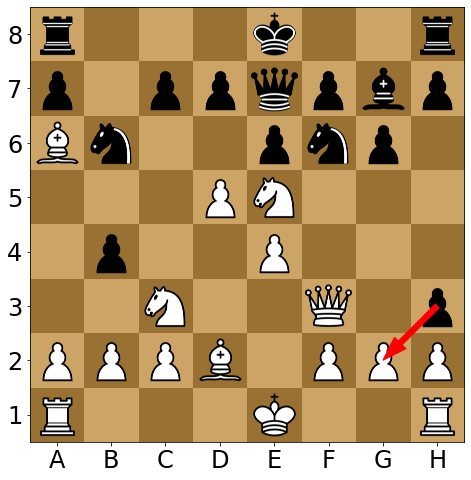

In [6]:
results_df = handle_output(output, 'Parallel v3 (basic)')
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

In [7]:
%%writefile parallelv3_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 10)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv3_minimax_alphabeta.py


In [8]:
%%capture output
!python parallelv3_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804


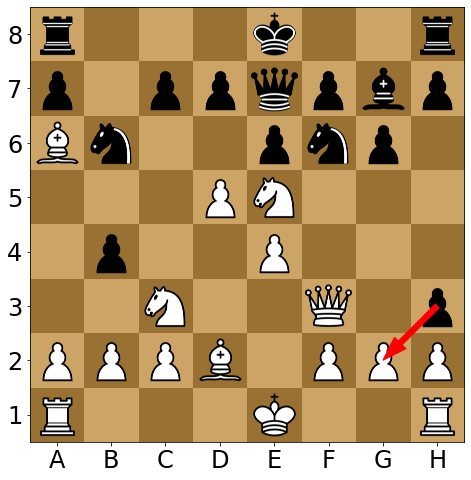

In [9]:
results_df = handle_output(output, 'Parallel v3 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

In [10]:
%%writefile parallelv3_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 11)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv3_minimax_alphabeta_movesorting.py


In [11]:
%%capture output
!python parallelv3_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138


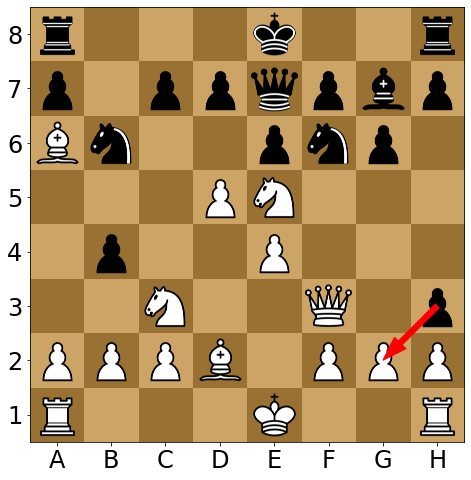

In [12]:
results_df = handle_output(output, 'Parallel v3 (alpha-beta + move sorting)', results_df)
results_df

### **PHIÊN BẢN SONG SONG 4**

#### Ý TƯỞNG

#### MINIMAX CƠ BẢN

In [13]:
%%writefile parallelv4_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 12)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv4_minimax_basic.py


In [14]:
%%capture output
!python parallelv4_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138
3,Parallel v4 (basic),-1.2,1.10492,3107697


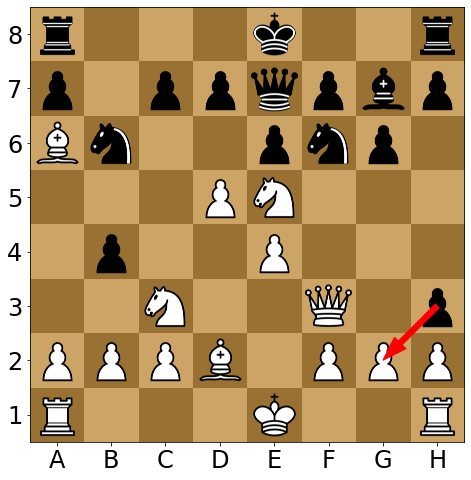

In [15]:
results_df = handle_output(output, 'Parallel v4 (basic)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

In [16]:
%%writefile parallelv4_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 13)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv4_minimax_alphabeta.py


In [17]:
%%capture output
!python parallelv4_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138
3,Parallel v4 (basic),-1.2,1.10492,3107697
4,Parallel v4 (alpha-beta),-1.2,0.78564,754772


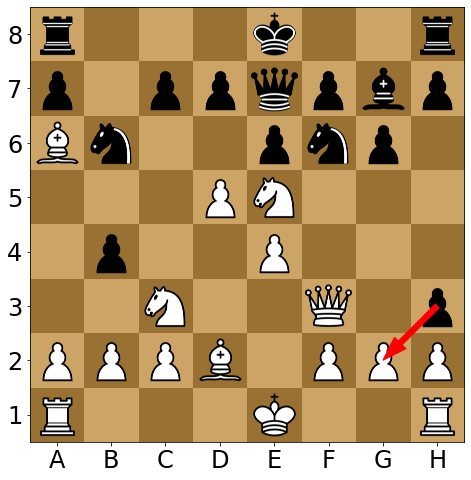

In [18]:
results_df = handle_output(output, 'Parallel v4 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

In [19]:
%%writefile parallelv4_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 14)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv4_minimax_alphabeta_movesorting.py


In [20]:
%%capture output
!python parallelv4_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138
3,Parallel v4 (basic),-1.2,1.10492,3107697
4,Parallel v4 (alpha-beta),-1.2,0.78564,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.38907,232047


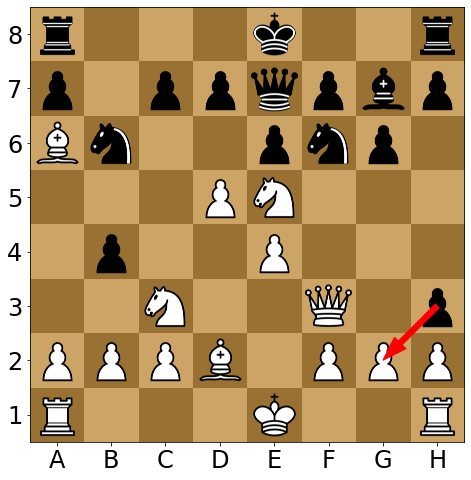

In [21]:
results_df = handle_output(output, 'Parallel v4 (alpha-beta + move sorting)', results_df)
results_df

### **PHIÊN BẢN SONG SONG 5**

#### Ý TƯỞNG

#### MINIMAX CƠ BẢN

In [22]:
%%writefile parallelv5_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 15)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv5_minimax_basic.py


In [23]:
%%capture output
!python parallelv5_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138
3,Parallel v4 (basic),-1.2,1.10492,3107697
4,Parallel v4 (alpha-beta),-1.2,0.78564,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.38907,232047
6,Parallel v5 (basic),-1.2,2.33263,3107697


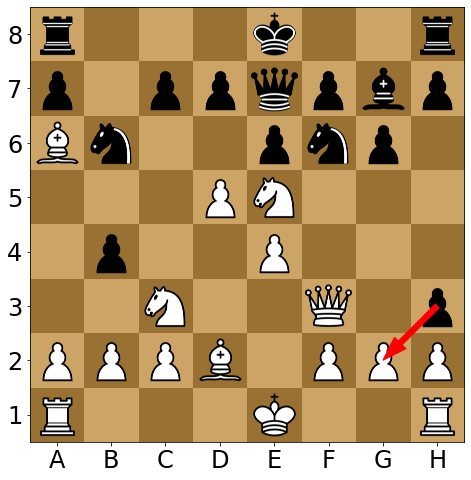

In [24]:
results_df = handle_output(output, 'Parallel v5 (basic)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

In [25]:
%%writefile parallelv5_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 16)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv5_minimax_alphabeta.py


In [26]:
%%capture output
!python parallelv5_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138
3,Parallel v4 (basic),-1.2,1.10492,3107697
4,Parallel v4 (alpha-beta),-1.2,0.78564,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.38907,232047
6,Parallel v5 (basic),-1.2,2.33263,3107697
7,Parallel v5 (alpha-beta),-1.2,0.19738,18803


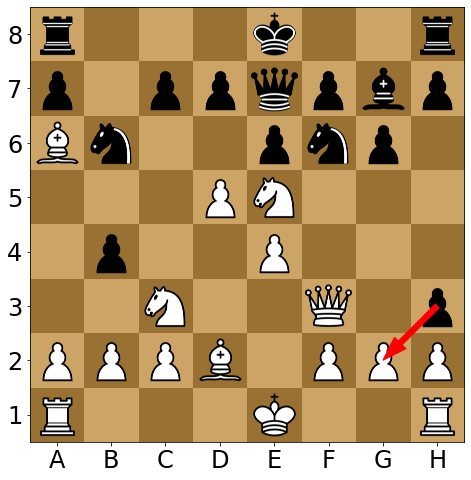

In [27]:
results_df = handle_output(output, 'Parallel v5 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

In [28]:
%%writefile parallelv5_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 17)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Writing parallelv5_minimax_alphabeta_movesorting.py


In [29]:
%%capture output
!python parallelv5_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.17428,3107697
1,Parallel v3 (alpha-beta),-1.2,0.31456,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.30966,12138
3,Parallel v4 (basic),-1.2,1.10492,3107697
4,Parallel v4 (alpha-beta),-1.2,0.78564,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.38907,232047
6,Parallel v5 (basic),-1.2,2.33263,3107697
7,Parallel v5 (alpha-beta),-1.2,0.19738,18803
8,Parallel v5 (alpha-beta + move sorting),-1.2,0.18182,10165


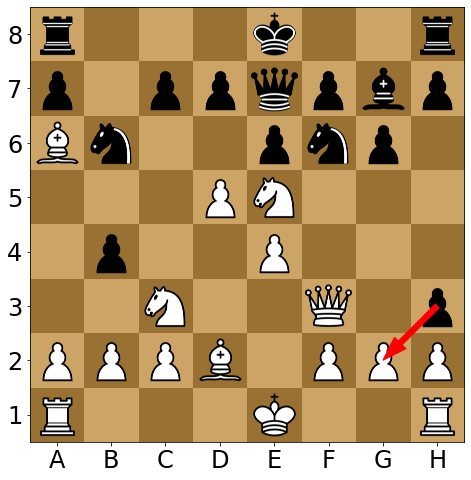

In [30]:
results_df = handle_output(output, 'Parallel v5 (alpha-beta + move sorting)', results_df)
results_df

In [31]:
results_df.to_csv('benchmark_results_p2.csv', index = False)

## **NHẬN XÉT**

In [33]:
results_df = pd.concat([old_results_df, results_df], ignore_index = True)
results_df

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,357.88707,3107697
1,Sequencial (alpha-beta),-1.2,2.10089,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.43835,8579
3,Parallel v1 (basic),-1.2,105.84559,3107697
4,Parallel v1 (alpha-beta),-1.2,3.67952,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.60420,102329
6,Parallel v2 (basic),-1.2,2.16347,3107697
7,Parallel v2 (alpha-beta),-1.2,0.28886,19804
8,Parallel v2 (alpha-beta + move sorting),-1.2,0.34249,12138
9,Parallel v3 (basic),-1.2,2.17428,3107697
